### Import Libraries

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetV2L
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### Prepare Dataset

In [ ]:
# Image Parameters
img_size = 224

def load_images_from_subfolders(parent_folder, label, noise_type):
    images = []
    labels = []
    subfolder_path = os.path.join(parent_folder, noise_type)
    for filename in os.listdir(subfolder_path):
        img_path = os.path.join(subfolder_path, filename)
        try:
            img = plt.imread(img_path)
            img_resized = cv2.resize(img, (img_size, img_size))
            images.append(img_resized)
            labels.append(label)
        except (OSError, ValueError) as e:
            print(f"Skipping non-image file: {img_path}, Error: {e}")
            continue
    return images, labels


#### Preprocesing

In [ ]:
# Function to apply median filter for salt-and-pepper noise
def median_filter(image, kernel_size=7):
    # Ensure the kernel size is odd
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be an odd number")

    # Get image dimensions
    height, width = image.shape

    # Pad the image to handle borders
    pad_size = kernel_size // 2
    padded_image = np.pad(image, pad_size, mode='reflect')

    # Initialize an empty array for the filtered image
    filtered_image = np.zeros_like(image)

    # Apply median filter
    for i in range(height):
        for j in range(width):
            # Extract the kernel region
            region = padded_image[i:i + kernel_size, j:j + kernel_size]
            # Calculate the median and assign it to the filtered image
            filtered_image[i, j] = np.median(region)

    return filtered_image

# Function to apply Wiener filter and deblur image
def apply_wiener_filter(image, kernel_size=21, noise_var=0.005, signal_var=0.15):
    # Define a motion blur kernel (example: a simple horizontal motion blur)
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    kernel = kernel / kernel_size

    # Wiener deblurring function for each channel
    def wiener_filter(image, kernel, noise_var=0.005, signal_var=0.15):
        # Convert image to float32 for processing
        image_f = np.float32(image)

        # Prepare the output image
        deblurred_image = np.zeros_like(image, dtype=np.float32)

        # Apply Wiener filter to each channel (RGB)
        for i in range(3):  # Loop over the 3 channels
            channel_f = np.fft.fft2(image_f[:, :, i])  # Fourier Transform of the current channel

            # Pad kernel to match the image size
            kernel_padded = np.zeros_like(image_f[:, :, i], dtype=np.float32)
            kernel_padded[:kernel.shape[0], :kernel.shape[1]] = kernel

            # Perform FFT on the padded kernel
            kernel_f = np.fft.fft2(kernel_padded)

            # Estimate the Wiener filter
            kernel_f_conj = np.conj(kernel_f)
            filter_wiener = kernel_f_conj / (np.abs(kernel_f)**2 + noise_var / signal_var)

            # Apply the Wiener filter in the frequency domain
            result_f = channel_f * filter_wiener
            deblurred_image[:, :, i] = np.abs(np.fft.ifft2(result_f))  # Inverse FFT and store in result
        return deblurred_image

    # Deblur the image using Wiener filter
    return wiener_filter(image, kernel)



**Images Reading**

In [ ]:
# A class to load images in batches, instead of load all of them at once
class CustomPreprocessingGenerator(tf.keras.utils.Sequence): # هذه الفانكشن تعمل ع تحميل الصور ع دفعات بدال ما ياخذ كل الصور مره وحده
    def __init__(self, file_paths, labels, noise_types, batch_size=32, target_size=(224, 224),
                 shuffle=True, aug_datagen=None):

        self.file_paths = file_paths
        self.labels = labels
        self.noise_types = noise_types
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.aug_datagen = aug_datagen
        self.on_epoch_end()

    def __len__(self): # تحسب عدد الدفعات  عدد الصور مقسومه ع عدد الدفعات
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def on_epoch_end(self): #
        if self.shuffle:
            idxs = np.arange(len(self.file_paths))
            np.random.shuffle(idxs)
            self.file_paths = [self.file_paths[i] for i in idxs]
            self.labels = [self.labels[i] for i in idxs]
            self.noise_types = [self.noise_types[i] for i in idxs]

    def __getitem__(self, index): #تقوم بتحميل دفعة واحدة من الصور.
        # Get batch indexes
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_paths = self.file_paths[start:end]
        batch_labels = self.labels[start:end]
        batch_noise = self.noise_types[start:end]

        # Load and preprocess images
        images = []
        for fp, nt in zip(batch_paths, batch_noise):
            # Load image
            img = load_img(fp, target_size=self.target_size)
            img = img_to_array(img)

            # Apply preprocessing based on noise type
            if nt == 'salt_and_pepper_noise':
                img = median_filter(img)
            elif nt == 'motion_blur':
                img = apply_wiener_filter(img)

            images.append(img)

        X = np.array(images, dtype=np.float32)
        y = np.array(batch_labels, dtype=np.int32)

        # Optionally apply augmentation
        if self.aug_datagen is not None:
            # Use the datagen to flow this batch once
            # We'll create a temporary generator for this batch
            aug_iter = self.aug_datagen.flow(X, y, batch_size=self.batch_size, shuffle=False)
            X, y = next(aug_iter)

        return X, y

def gather_file_paths_and_labels(root_dir, classes=('cats','dogs')):

    file_paths = []
    labels = []
    noise_types = []

    for class_name in classes:
        class_path = os.path.join(root_dir, class_name) #إنشاء المسار الخاص بكل فئة باستخدام:

        class_label = 0 if class_name == 'cats' else 1

        # Suppose all images are in this directory, and we can identify noise type by filename:
        # If they are separated into subfolders like: class_path/salt_and_pepper_noise/ and class_path/motion_blur/,
        # you can walk those directories and set noise types accordingly.

        salt_dir = os.path.join(class_path, 'salt_and_pepper_noise')
        if os.path.exists(salt_dir):
            for f in os.listdir(salt_dir):
                if f.lower().endswith(('jpg','jpeg','png')):
                    file_paths.append(os.path.join(salt_dir, f))
                    labels.append(class_label)
                    noise_types.append('salt_and_pepper_noise')

        blur_dir = os.path.join(class_path, 'motion_blur')
        if os.path.exists(blur_dir):
            for f in os.listdir(blur_dir):
                if f.lower().endswith(('jpg','jpeg','png')):
                    file_paths.append(os.path.join(blur_dir, f))
                    labels.append(class_label)
                    noise_types.append('motion_blur')

    return file_paths, labels, noise_types


train_dir = r'/kaggle/input/cats-dogs-dataset/dataset/training_set'  # Path to training data
test_dir = r'/kaggle/input/cats-dogs-dataset/dataset/test_set'  # Path to test data

#2. جمع بيانات التدريب والتقييم
train_file_paths, train_labels, train_noise_types = gather_file_paths_and_labels(train_dir, classes=('cats', 'dogs'))
val_file_paths, val_labels, val_noise_types = gather_file_paths_and_labels(test_dir, classes=('cats', 'dogs'))

# Create an ImageDataGenerator to read images in batches #يتم إنشاء كائنين من ImageDataGenerator (واحد للتدريب والآخر للتقييم):

train_aug_datagen = ImageDataGenerator()
val_aug_datagen = ImageDataGenerator()

#3.2. إعداد بيانات التدريب
train_gen = CustomPreprocessingGenerator(
    file_paths=train_file_paths,
    labels=train_labels,
    noise_types=train_noise_types,
    batch_size=32,
    target_size=(224,224),
    shuffle=True,
    aug_datagen=train_aug_datagen
)

val_gen = CustomPreprocessingGenerator(
    file_paths=val_file_paths,
    labels=val_labels,
    noise_types=val_noise_types,
    batch_size=32,
    target_size=(224,224),
    shuffle=False,
    aug_datagen=val_aug_datagen
)

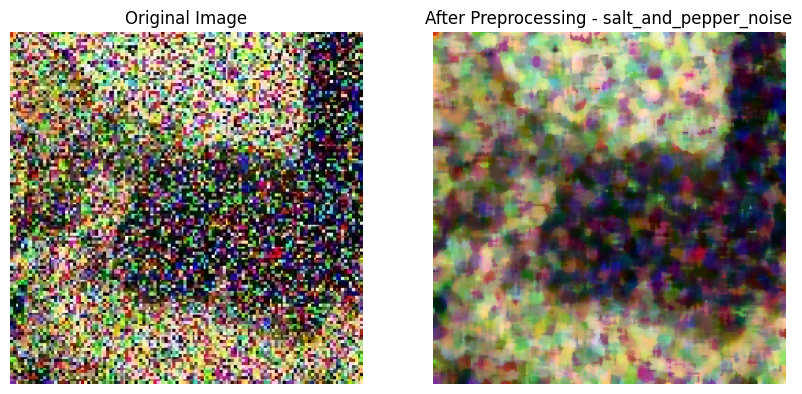

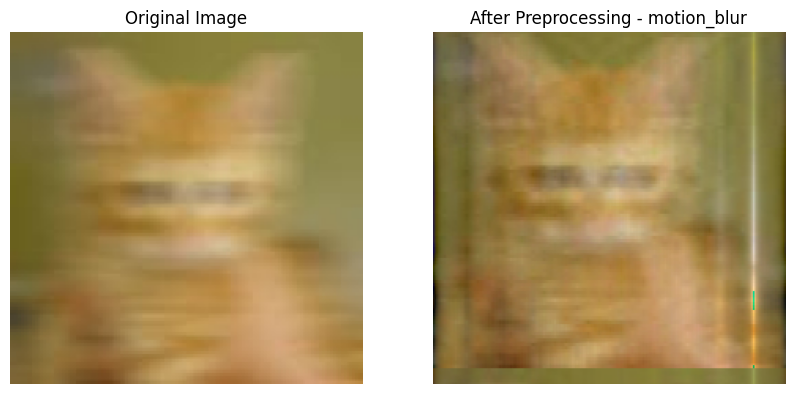

In [ ]:
def display_before_after(img_path, noise_type):

    # Load the original image
    original_img = load_img(img_path, target_size=(img_size, img_size))
    original_img_array = img_to_array(original_img)

    # Apply preprocessing if necessary
    if noise_type == 'salt_and_pepper_noise':
        preprocessed_img_array = median_filter(original_img_array)
    elif noise_type == 'motion_blur':
        preprocessed_img_array = apply_wiener_filter(original_img_array)

    # Convert images to displayable format
    original_img_display = original_img_array.astype(np.uint8)
    preprocessed_img_display = preprocessed_img_array.astype(np.uint8)

    # Plot the before and after images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img_display.astype(np.uint8))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed_img_display.astype(np.uint8))
    plt.title(f'After Preprocessing - {noise_type}')
    plt.axis('off')

    plt.show()


display_before_after(train_file_paths[0], train_noise_types[0])
display_before_after(train_file_paths[5001], train_noise_types[5001])


In [ ]:
def create_enhanced_cnn_model(input_shape):
    # Load the EfficientNetV2L model without the top layer (include_top=False)
    base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add classification head
    model = Sequential([
        base_model,
        GlobalMaxPooling2D(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    return model

# Fixed hyperparameters
learning_rate = 0.0001
batch_size = 32
epochs = 150

# Create model with updated architecture
model = create_enhanced_cnn_model(input_shape=(224, 224, 3))

# Compile model with AdamW optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Directory to save the best model and weights
model_dir = "sgd_newlr"
os.makedirs(model_dir, exist_ok=True)
best_model_path = os.path.join(model_dir, "best_model.keras")

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-8)

model_checkpoint = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    verbose=1
)

# Save the history of the training process
history_path = os.path.join(model_dir, "history.npy")
np.save(history_path, history.history)  # Save history to file

print(f"Best model saved at: {best_model_path}")
print(f"Training history saved at: {history_path}")



473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
Epoch 1/150


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734290703.696540      68 service.cc:145] XLA service 0x7bfbac005a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734290703.696597      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734291137.403814      68 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_36', 32 bytes spill stores, 32 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_35', 244 bytes spill stores, 244 bytes 

500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.6483 - loss: 0.7966
Epoch 1: val_accuracy improved from -inf to 0.86625, saving model to sgd_newlr/best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 976s 794ms/step - accuracy: 0.6485 - loss: 0.7961 - val_accuracy: 0.8662 - val_loss: 0.3125 - learning_rate: 1.0000e-04
Epoch 2/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.8388 - loss: 0.3541
Epoch 2: val_accuracy improved from 0.86625 to 0.89425, saving model to sgd_newlr/best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 375s 743ms/step - accuracy: 0.8388 - loss: 0.3541 - val_accuracy: 0.8942 - val_loss: 0.2471 - learning_rate: 1.0000e-04
Epoch 3/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.8856 - loss: 0.2655
Epoch 3: val_accuracy improved from 0.89425 to 0.90350, saving model to sgd_newlr/best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 375s 743ms/step - accuracy: 0.8856 - loss: 0.2655 - val_accuracy: 0.9035 - val_loss: 0.2244 - learning_rate: 1.0000e-04
Epoc

In [ ]:
# Load the best model
best_model = tf.keras.models.load_model("/kaggle/input/cats-dogs-models/sgd_newlr/best_model.keras")

# Evaluate the best model on validation data
val_loss, val_accuracy = best_model.evaluate(val_gen, verbose=1)
print(f"Best Validation Accuracy: {val_accuracy:.4f}")

Best Validation Accuracy: 0.9122


Training history loaded from: /kaggle/input/cats-dogs-models/sgd_newlr/history.npy


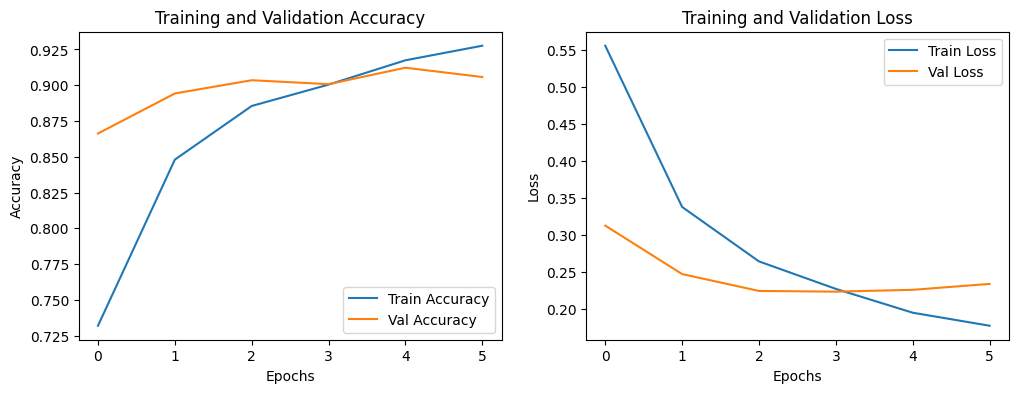

Loaded model from: /kaggle/input/cats-dogs-models/sgd_newlr/best_model.keras


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734295269.472029     113 service.cc:145] XLA service 0x7b8d000031b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734295269.472108     113 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/125 ━━━━━━━━━━━━━━━━━━━━ 55:40 27s/step - accuracy: 0.9375 - loss: 0.2677

I0000 00:00:1734295281.115975     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 313ms/step - accuracy: 0.9023 - loss: 0.2777
Test Set Accuracy: 0.9122


In [ ]:
# Load the training history
history_path = "/kaggle/input/cats-dogs-models/sgd_newlr/history.npy"  # Update with the correct path if needed
history_dict = np.load(history_path, allow_pickle=True).item()  # Load history as a dictionary
print(f"Training history loaded from: {history_path}")

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Load the best model
best_model_path = "/kaggle/input/cats-dogs-models/sgd_newlr/best_model.keras"
best_model = tf.keras.models.load_model(best_model_path)
print(f"Loaded model from: {best_model_path}")

val_loss, val_accuracy = best_model.evaluate(val_gen, verbose=1)
print(f"Test Set Accuracy: {val_accuracy:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step


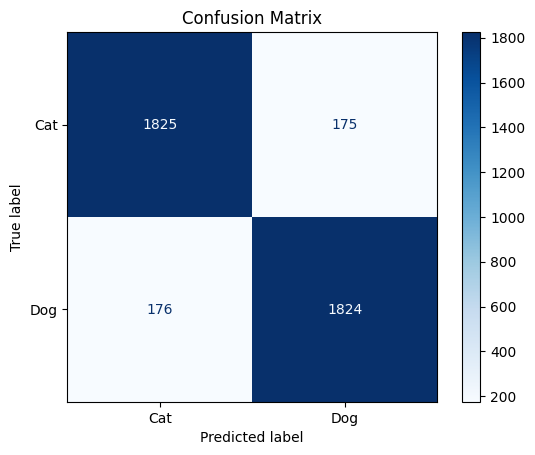

In [ ]:
y_true_list = []
for i in range(len(val_gen)):
    _, y_batch = val_gen[i]
    y_true_list.append(y_batch)
y_true = np.concatenate(y_true_list)


# Get predictions
y_pred = best_model.predict(val_gen)
# Convert probabilities to class labels (0 or 1)
y_pred_classes = (y_pred > 0.5).astype("int32").ravel()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Cat", "Dog"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

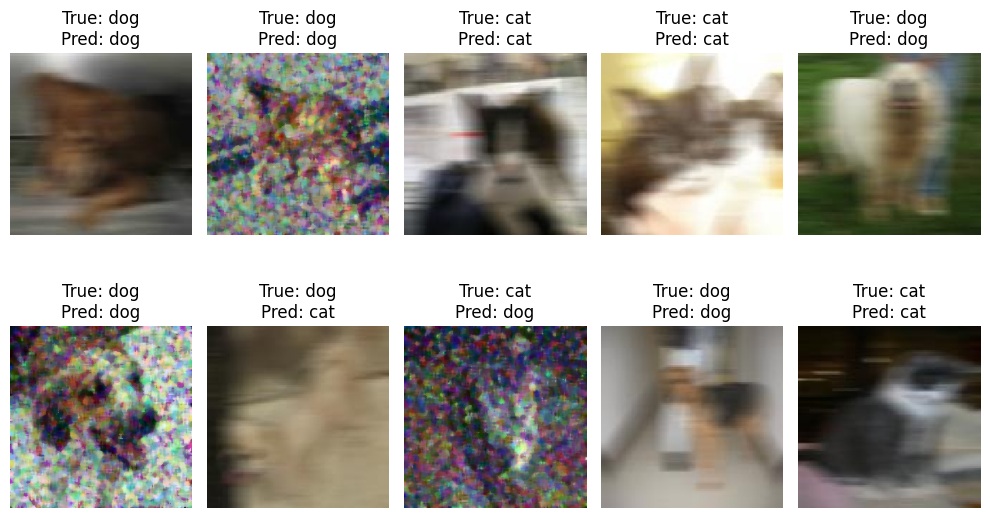

In [ ]:
# Number of samples and rows to display
num_samples = 10  # Total number of samples to display
num_cols = 5      # Number of columns per row
num_rows = (num_samples + num_cols - 1) // num_cols  # Calculate required rows

# Select random indices from the validation set
random_indices = np.random.choice(len(y_true), num_samples, replace=False)

# Plot the random predictions
plt.figure(figsize=(10, num_rows * 3))

for i, idx in enumerate(random_indices):
    # Get the image and true label from the validation generator
    batch_index = idx // val_gen.batch_size
    image_index = idx % val_gen.batch_size

    x_batch, y_batch = val_gen[batch_index]
    image = x_batch[image_index]
    true_label = 'dog' if y_batch[image_index] == 1 else 'cat'
    pred_label = 'dog' if y_pred_classes[idx] == 1 else 'cat'

    # Display the image
    plt.subplot(num_rows, num_cols, i + 1)
    image = image.astype(np.uint8)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'True: {true_label}\nPred: {pred_label}')

plt.tight_layout()
plt.show()
